In [15]:
!pip install pandas numpy xgboost seaborn scipy scikit-learn matplotlib optuna


In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from scipy.stats import skew
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
import warnings
import optuna
import logging
import ast
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import pickle


In [17]:
class NumericalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, model=HistGradientBoostingRegressor()):
        self.model = model
        self.numerical_columns = None
        self.models = {}

    def fit(self, X, y=None):
        X = X.copy()

        self.numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

        for col in self.numerical_columns:
            X_features = X[self.numerical_columns].drop(columns=[col])
            mask = X[col].notna()

            X_train = X_features.loc[mask]
            y_train = X.loc[mask, col]

            if len(X_train) > 10:
                model = clone(self.model)
                model.fit(X_train, y_train)
                self.models[col] = model

        return self

    def transform(self, X):
        X_copy = X.copy()

        for col in self.numerical_columns:
            mask = X_copy[col].isna()
            if mask.sum() == 0:
                continue

            if col in self.models:
                X_features = X_copy[self.numerical_columns].drop(columns=[col])
                X_missing = X_features.loc[mask]

                predicted = self.models[col].predict(X_missing)
                X_copy.loc[mask, col] = predicted

        return X_copy


In [18]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, model=HistGradientBoostingClassifier()):
        self.model = model
        self.categorical_columns = None
        self.models = {}

    def fit(self, X, y=None):
        X = X.copy()


        self.categorical_columns = X.select_dtypes(include=['object', 'category']).columns

        for col in self.categorical_columns:
            if pd.isnull(X[col]).sum() > 0:
                most_frequent = X[col].mode()[0]
                X[col].fillna(most_frequent, inplace=True)
        return self

    def transform(self, X):
        X_copy = X.copy()

        for col in self.categorical_columns:
            if pd.isnull(X_copy[col]).sum() > 0:
                most_frequent = X_copy[col].mode()[0]
                X_copy[col].fillna(most_frequent, inplace=True)
        return X_copy

In [19]:
class XOutlierRemover:
    def __init__(self, iqr_multiplier=3.0):
        self.boundaries_X = {}
        self.iqr_multiplier = iqr_multiplier

    def fit(self, X_train):
        for col in X_train.select_dtypes(include=['float64', 'int64']).columns:
            if X_train[col].nunique() <= 1:
                continue

            Q1 = X_train[col].quantile(0.25)
            Q3 = X_train[col].quantile(0.75)
            IQR = Q3 - Q1

            if IQR == 0:
                continue

            lower_bound = Q1 - self.iqr_multiplier * IQR
            upper_bound = Q3 + self.iqr_multiplier * IQR
            self.boundaries_X[col] = (lower_bound, upper_bound)
        return self

    def transform(self, X, y):
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)

        original_count = len(X)

        mask_X = np.ones(X.shape[0], dtype=bool)

        removed_per_column = {}
        for col in self.boundaries_X:
            if col not in X.columns:
                continue
            lower, upper = self.boundaries_X[col]
            col_mask = (X[col] >= lower) & (X[col] <= upper)
            removed = (~col_mask).sum()

            if removed / len(X) <= 0.25:
                mask_X &= col_mask
                removed_per_column[col] = removed
            else:
                print(f"[XOutlierRemover] Warning: Column {col} would remove {removed} rows ({removed/len(X)*100:.1f}%). Skipping.")

        removed = (~mask_X).sum()
        print(f"[XOutlierRemover] Previous number of rows: {original_count}")
        print(f"[XOutlierRemover] Removed {removed} rows with outliers in X.")
        print(f"[XOutlierRemover] After removing left: {mask_X.sum()}")

        if mask_X.sum() == 0:
            print("[XOutlierRemover] WARNING: All rows would be removed! Returning original data instead.")
            return X, y

        return X[mask_X].reset_index(drop=True), y[mask_X].reset_index(drop=True)


class YOutlierRemover:
    def __init__(self, iqr_multiplier=3.0):
        self.lower = None
        self.upper = None
        self.iqr_multiplier = iqr_multiplier

    def fit(self, y):
        if len(y) == 0:
            print("[YOutlierRemover] Warning: Empty dataset provided for fitting")
            return self

        Q1 = y.quantile(0.25)
        Q3 = y.quantile(0.75)
        IQR = Q3 - Q1

        if IQR == 0:
            print("[YOutlierRemover] Warning: IQR is zero, using min/max instead")
            self.lower = y.min()
            self.upper = y.max()
        else:
            self.lower = Q1 - self.iqr_multiplier * IQR
            self.upper = Q3 + self.iqr_multiplier * IQR
        return self

    def transform(self, X, y):
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)

        if self.lower is None or self.upper is None:
            print("[YOutlierRemover] Warning: Boundaries not set. Call fit() first.")
            return X, y

        mask_y = (y >= self.lower) & (y <= self.upper)
        removed_rows = (~mask_y).sum()

        if removed_rows / len(y) > 0.25:
            print(f"[YOutlierRemover] WARNING: Would remove {removed_rows} rows ({removed_rows/len(y)*100:.1f}%). Returning original data.")
            return X, y

        print(f"[YOutlierRemover] Previous number of rows: {len(y)}")
        print(f"[YOutlierRemover] Removed {removed_rows} rows with outliers in y.")
        print(f"[YOutlierRemover] After removing left: {mask_y.sum()}")

        if mask_y.sum() == 0:
            print("[YOutlierRemover] WARNING: All rows would be removed! Returning original data instead.")
            return X, y

        return X[mask_y].reset_index(drop=True), y[mask_y].reset_index(drop=True)


In [20]:
def evaluate_model(model, X_train, y_train, n_splits=3, seed=42):
    scores_learning_curve = []
    imputers = []
    encoders = []
    scalers = []
    scores = []
    train_errors = []
    val_errors = []
    y_outlier_removers = []
    X_outlier_removers = []


    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx].copy()
        X_val = X_train.iloc[val_idx].copy()
        y_tr = y_train.iloc[train_idx].copy()
        y_val = y_train.iloc[val_idx].copy()

        num_imputer = NumericalImputer().fit(X_tr)
        X_tr = num_imputer.transform(X_tr)
        X_val = num_imputer.transform(X_val)

        categorical_columns = X_tr.select_dtypes(include=['object', 'category']).columns.tolist()
        print("Kategorie:", categorical_columns)

        numeric_columns = X_tr.select_dtypes(include=["int64", "float64"]).columns

        categorical_imputer = CategoricalImputer().fit(X_tr)
        X_tr = categorical_imputer.transform(X_tr)
        X_val = categorical_imputer.transform(X_val)

        numeric_columns = X_tr.select_dtypes(include=["int64", "float64"]).columns
        if (np.any(np.isnan(X_tr[numeric_columns])) or np.any(np.isinf(X_tr[numeric_columns])) or
            np.any(np.isnan(X_val[numeric_columns])) or np.any(np.isinf(X_val[numeric_columns])) or
            np.any(np.isnan(y_tr)) or np.any(np.isinf(y_tr)) or
            np.any(np.isnan(y_val)) or np.any(np.isinf(y_val))):
            print("NaN/inf values — fold skipped")
            continue

        y_outlier_remover = YOutlierRemover(iqr_multiplier=5.0)
        y_outlier_remover.fit(y_tr)
        X_tr, y_tr = y_outlier_remover.transform(X_tr, y_tr)
        X_val, y_val = y_outlier_remover.transform(X_val, y_val)

        X_outlier_remover = XOutlierRemover(iqr_multiplier=5.0)
        X_outlier_remover.fit(X_tr)
        X_tr, y_tr = X_outlier_remover.transform(X_tr, y_tr)
        X_val, y_val = X_outlier_remover.transform(X_val, y_val)

        existing_categorical_columns = [col for col in categorical_columns if col in X_tr.columns]
        if existing_categorical_columns:
            encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

            X_tr_encoded = encoder.fit_transform(X_tr[existing_categorical_columns])
            X_val_encoded = encoder.transform(X_val[existing_categorical_columns])

            encoded_columns = encoder.get_feature_names_out(existing_categorical_columns)

            X_tr = X_tr.drop(columns=existing_categorical_columns).reset_index(drop=True)
            X_val = X_val.drop(columns=existing_categorical_columns).reset_index(drop=True)

            X_tr_encoded_df = pd.DataFrame(X_tr_encoded, columns=encoded_columns)
            X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=encoded_columns)

            X_tr = pd.concat([X_tr, X_tr_encoded_df], axis=1)
            X_val = pd.concat([X_val, X_val_encoded_df], axis=1)

            encoders.append(encoder)

            print("Po OneHotEncode:")
        else:
            print("No categorical columns for encdoing.")
            encoders.append(None)

        scaler = MinMaxScaler()
        X_tr[numeric_columns] = scaler.fit_transform(X_tr[numeric_columns])
        X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])

        scalers.append(scaler)


        processed_data_path = 'data/processed/'
        os.makedirs(processed_data_path, exist_ok=True)
        X_tr.to_csv(processed_data_path + 'X_processed.csv', index=False)
        y_tr.to_csv(processed_data_path + 'y_processed.csv', index=False)

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        score = -mean_absolute_error(y_val, preds)
        scores.append(score)
        imputers.append((num_imputer, categorical_imputer))


        y_outlier_removers.append(y_outlier_remover)
        X_outlier_removers.append(X_outlier_remover)

        print(f"Score: {score}")
        print(f"Prediction: {preds[:5]}...")

    if not scores:
        print("No valid folds")
        return float("-inf"), None, None, None, None

    return np.mean(scores), imputers[-1][0], imputers[-1][1], encoders[-1], scalers[-1],  X_tr, y_tr, X_val, y_val, y_outlier_removers[-1], X_outlier_removers[-1]

In [21]:
def clean_verifications(val):
    if pd.isnull(val):
        return None
    try:
        items = ast.literal_eval(val)
        if isinstance(items, list):
            return "_".join(sorted(items))
    except:
        return None

In [22]:
def objective(trial, X_train, y_train):
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 50, 150),
    "booster": "gbtree",
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05, log=True),
    "max_depth": trial.suggest_int("max_depth", 2, 4),
    "min_child_weight": trial.suggest_int("min_child_weight", 10, 20),
    "subsample": trial.suggest_float("subsample", 0.4, 0.7),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 0.7),
    "reg_lambda": trial.suggest_float("reg_lambda", 10.0, 20.0),
    "gamma": trial.suggest_float("gamma", 2.0, 10.0),
    "reg_alpha": trial.suggest_float("reg_alpha", 1.0, 3.0),
    "tree_method": "hist",
    "random_state": 42,
    "n_jobs": -1
}



    print(f"Testing trial with params: {params}")

    try:
        model = xgb.XGBRegressor(**params)

        numerical_columns = X_train.select_dtypes(include=["number"]).columns

        score, num_imputer, cat_imputer, encoder, scaler, X_tr, y_tr, x_val, y_val, y_outlier_removers, X_outlier_removers = evaluate_model(model, X_train, y_train, n_splits=3)


        print(f"Score: {score}, type: {type(score)}")
        if np.isnan(score) or np.isinf(score):
            print(f"[Trial {trial.number}] Invalid score: {score}")
            return float("-inf")

        trial.set_user_attr("model", model)
        trial.set_user_attr("imputers", (num_imputer, cat_imputer))
        trial.set_user_attr("encoder", encoder)
        trial.set_user_attr("scaler", scaler)
        trial.set_user_attr("x_tr", X_tr)
        trial.set_user_attr("y_tr", y_tr)
        trial.set_user_attr("x_val", x_val)
        trial.set_user_attr("y_val", y_val)
        trial.set_user_attr("y_outlier_removers", y_outlier_removers)
        trial.set_user_attr("X_outlier_removers", X_outlier_removers)

        print(f"[Trial {trial.number}] Done with score: {score}")
        return score

    except Exception as e:
        print(f"[Trial {trial.number}] Error: {e}")
        return float("-inf")

In [23]:
def plot_learning_curve_vs_data_size(estimator, X, y, scoring="neg_mean_squared_error", cv=3, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring=scoring,
        train_sizes=train_sizes,
        n_jobs=-1
    )

    train_errors = -np.mean(train_scores, axis=1)
    val_errors = -np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_errors, 'o-', label='Training Error')
    plt.plot(train_sizes, val_errors, 'o-', label='Validation Error')
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve (Train Size vs Error)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [24]:
def remove_percentage_and_convert_column(df, column_name):
    df[column_name] = df[column_name].replace({'%': ''}, regex=True).astype(float) / 100
    return df

In [25]:
def extract_year(date_str):
    if pd.isna(date_str):
        return None

    if isinstance(date_str, float):
        return int(date_str)

    if isinstance(date_str, str):
        try:
            if "/" in date_str:
                return int(date_str.split("/")[-1])
            elif "-" in date_str:
                return int(date_str.split("-")[0])
            else:
                raise ValueError(f"Unknown date format: {date_str}")
        except Exception as e:
            print(f"Error processing date: {e}")
            return None
    else:
        return None


In [26]:
def transform_with_best_pipeline(X_trans, num_imputer, cat_imputer, encoder, scaler, X_train_columns):
    X_trans = num_imputer.transform(X_trans)

    X_trans = cat_imputer.transform(X_trans)

    if encoder:
        categorical_columns = [col for col in X_trans.columns if X_trans[col].dtype in ['object', 'category']]

        if categorical_columns:
            X_encoded = encoder.transform(X_trans[categorical_columns])

            X_trans = X_trans.drop(columns=categorical_columns).reset_index(drop=True)

            new_columns = encoder.get_feature_names_out(categorical_columns)

            X_encoded_df = pd.DataFrame(X_encoded, columns=new_columns)

            X_trans = pd.concat([X_trans.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)


    if scaler:
      numeric_cols = [col for col in X_trans.select_dtypes(include=["int64", "float64"]).columns if set(X_trans[col].dropna().unique()) - {0, 1}]
      X_trans[numeric_cols] = scaler.transform(X_trans[numeric_cols])

    return X_trans


In [27]:

pd.set_option('display.max_columns', None)

In [28]:

from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/DataXproject/listings.csv'
df = pd.read_csv(file_path)


Mounted at /content/drive


In [29]:

print(df.head())

       id                          listing_url       scrape_id last_scraped  \
0   23163   https://www.airbnb.com/rooms/23163  20250316041547   2025-03-16   
1   23169   https://www.airbnb.com/rooms/23169  20250316041547   2025-03-16   
2   26755   https://www.airbnb.com/rooms/26755  20250316041547   2025-03-16   
3  782440  https://www.airbnb.com/rooms/782440  20250316041547   2025-03-16   
4  782489  https://www.airbnb.com/rooms/782489  20250316041547   2025-03-16   

        source                                 name  \
0  city scrape         Residence Karolina - KAROL12   
1  city scrape           Residence Masna - Masna302   
2  city scrape    Central Prague Old Town Top Floor   
3  city scrape  Central,Cheap&Lovely Miniapartment2   
4  city scrape  Central,Cheap&Lovely Miniapartment3   

                                         description  \
0  Unique and elegant apartment rental in Prague,...   
1  Masna studio offers a lot of space and privacy...   
2  Big and beautiful new a

In [30]:
print(df.describe(include="all"))

                  id                                       listing_url  \
count   1.010800e+04                                             10108   
unique           NaN                                             10108   
top              NaN  https://www.airbnb.com/rooms/1376687962067046501   
freq             NaN                                                 1   
mean    6.108089e+17                                               NaN   
std     5.380318e+17                                               NaN   
min     2.316300e+04                                               NaN   
25%     3.280956e+07                                               NaN   
50%     7.446005e+17                                               NaN   
75%     1.128376e+18                                               NaN   
max     1.376688e+18                                               NaN   

           scrape_id last_scraped       source  \
count   1.010800e+04        10108        10108   
unique     

In [31]:
df.drop_duplicates()

id                                       listing_url  \
0                    23163                https://www.airbnb.com/rooms/23163   
1                    23169                https://www.airbnb.com/rooms/23169   
2                    26755                https://www.airbnb.com/rooms/26755   
3                   782440               https://www.airbnb.com/rooms/782440   
4                   782489               https://www.airbnb.com/rooms/782489   
...                    ...                                               ...   
10103  1376060147333170094  https://www.airbnb.com/rooms/1376060147333170094   
10104  1376107366525720427  https://www.airbnb.com/rooms/1376107366525720427   
10105  1376200880174065144  https://www.airbnb.com/rooms/1376200880174065144   
10106  1376226802447337647  https://www.airbnb.com/rooms/1376226802447337647   
10107  1376687962067046501  https://www.airbnb.com/rooms/1376687962067046501   

            scrape_id last_scraped       source  \
0      20250316041547   2025-03-16  city scrape   
1      20250316041547   2025-03-16  city scrape   
2      20250316041547   2025-03-16  city scrape   
3      20250316041547   2025-03-16  city scrape   
4      20250316041547   2025-03-16  city scrape   
...               ...          ...          ...   
10103  20250316041547   2025-03-16  city scrape   
10104  20250316041547   2025-03-16  city scrape   
10105  20250316041547   2025-03-16  city scrape   
10106  20250316041547   2025-03-16  city scrape   
10107  20250316041547   2025-03-16  city scrape   

                                                 name  \
0                        Residence Karolina - KAROL12   
1                          Residence Masna - Masna302   
2                   Central Prague Old Town Top Floor   
3                 Central,Cheap&Lovely Miniapartment2   
4                 Central,Cheap&Lovely Miniapartment3   
...                                               ...   
10103           Prague Charm Apartment in Mala Strana   
10104                                   Karmelitska 2   
10105                                 Cozy apartments   
10106                   Apartmán u metra s parkováním   
10107  Magnificent Apartment with Sauna and Billiards   

                                             description  \
0      Unique and elegant apartment rental in Prague,...   
1      Masna studio offers a lot of space and privacy...   
2      Big and beautiful new attic apartment in the v...   
3      See all our offers on Airbnb!<br />www.airbnb....   
4      See all our offers on Airbnb!<br />www.airbnb....   
...                                                  ...   
10103                                                NaN   
10104  Enjoy a stylish experience at this centrally-l...   
10105  the apartments are located 1 minute from the t...   
10106  The apartment is  fully equipped and is locate...   
10107  This remarkable 6-room apartment features 3 ki...   

                                   neighborhood_overview  \
0                                                    NaN   
1                                                    NaN   
2      This apartment offers a fantastic location. Yo...   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
10103                                                NaN   
10104                                                NaN   
10105                                                NaN   
10106                                                NaN   
10107  Welcome to our exceptional Airbnb apartment, p...   

                                             picture_url    host_id  \
0      https://a0.muscache.com/pictures/01bbe32c-3f13...       5282   
1      https://a0.muscache.com/pictures/b450cf2a-8561...       5282   
2      https://a0.muscache.com/pictures/miso/Hosting-...     113902   
3      https://a0.muscache.com/pictures

In [32]:
print(df.isnull().sum())

id                                                0
listing_url                                       0
scrape_id                                         0
last_scraped                                      0
source                                            0
                                               ... 
calculated_host_listings_count                    0
calculated_host_listings_count_entire_homes       0
calculated_host_listings_count_private_rooms      0
calculated_host_listings_count_shared_rooms       0
reviews_per_month                               975
Length: 79, dtype: int64


In [33]:
df["price"] = df["price"].replace(r"[\$,]", "", regex=True).astype(float)

In [34]:
df["price"].describe()

count      8808.000000
mean       2730.524977
std        8349.628162
min         223.000000
25%        1242.750000
50%        1762.000000
75%        2641.000000
max      251025.000000
Name: price, dtype: float64

In [35]:
df.head()

id                          listing_url       scrape_id last_scraped  \
0   23163   https://www.airbnb.com/rooms/23163  20250316041547   2025-03-16   
1   23169   https://www.airbnb.com/rooms/23169  20250316041547   2025-03-16   
2   26755   https://www.airbnb.com/rooms/26755  20250316041547   2025-03-16   
3  782440  https://www.airbnb.com/rooms/782440  20250316041547   2025-03-16   
4  782489  https://www.airbnb.com/rooms/782489  20250316041547   2025-03-16   

        source                                 name  \
0  city scrape         Residence Karolina - KAROL12   
1  city scrape           Residence Masna - Masna302   
2  city scrape    Central Prague Old Town Top Floor   
3  city scrape  Central,Cheap&Lovely Miniapartment2   
4  city scrape  Central,Cheap&Lovely Miniapartment3   

                                         description  \
0  Unique and elegant apartment rental in Prague,...   
1  Masna studio offers a lot of space and privacy...   
2  Big and beautiful new attic apartment in the v...   
3  See all our offers on Airbnb!<br />www.airbnb....   
4  See all our offers on Airbnb!<br />www.airbnb....   

                               neighborhood_overview  \
0                                                NaN   
1                                                NaN   
2  This apartment offers a fantastic location. Yo...   
3                                                NaN   
4                                                NaN   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/01bbe32c-3f13...     5282   
1  https://a0.muscache.com/pictures/b450cf2a-8561...     5282   
2  https://a0.muscache.com/pictures/miso/Hosting-...   113902   
3  https://a0.muscache.com/pictures/11243352/ad21...  4102236   
4  https://a0.muscache.com/pictures/35821920/aee6...  4102236   

                                    host_url   host_name  host_since  \
0     https://www.airbnb.com/users/show/5282       Klara  2008-12-17   
1     https://www.airbnb.com/users/show/5282       Klara  2008-12-17   
2   https://www.airbnb.com/users/show/113902  Daniel+Bea  2010-04-26   
3  https://www.airbnb.com/users/show/4102236       Bonny  2012-11-09   
4  https://www.airbnb.com/users/show/4102236       Bonny  2012-11-09   

     host_location                                         host_about  \
0  Prague, Czechia  Hello, \r\nglad to see that you are interested...   
1  Prague, Czechia  Hello, \r\nglad to see that you are interested...   
2  Prague, Czechia  Hi! we are a sp/cz couple with 2 daughters (La...   
3  Prague, Czechia  We love traveling, culture, good food and meet...   
4  Prague, Czechia  We love traveling, culture, good food and meet...   

  host_response_time host_response_rate host_acceptance_rate  \
0     within an hour               100%                 100%   
1     within an hour               100%                 100%   
2     within an hour               100%                  98%   
3     within an hour               100%                  80%   
4     within an hour               100%                  80%   

  host_is_superhost                                 host_thumbnail_url  \
0                 t  https://a0.muscache.com/im/pictures/user/b7309...   
1                 t  https://a0.muscache.com/im/pictures/user/b7309...   
2                 t  https://a0.muscache.com/im/pictures/user/8db01...   
3                 t  https://a0.muscache.com/im/users/4102236/profi...   
4                 t  https://a0.muscache.com/im/users/4102236/profi...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/user/b7309...            Josefov   
1  https://a0.muscache.com/im/pictures/user/b7309...            Josefov   
2  https://a0.muscache.com/im/pictures/user/8db01...        Staré Město   
3  https://a0.muscache.com/im/users/4102236/profi...             Žižkov   
4  https://a0.muscache.com/im/users/4102236/profi...       

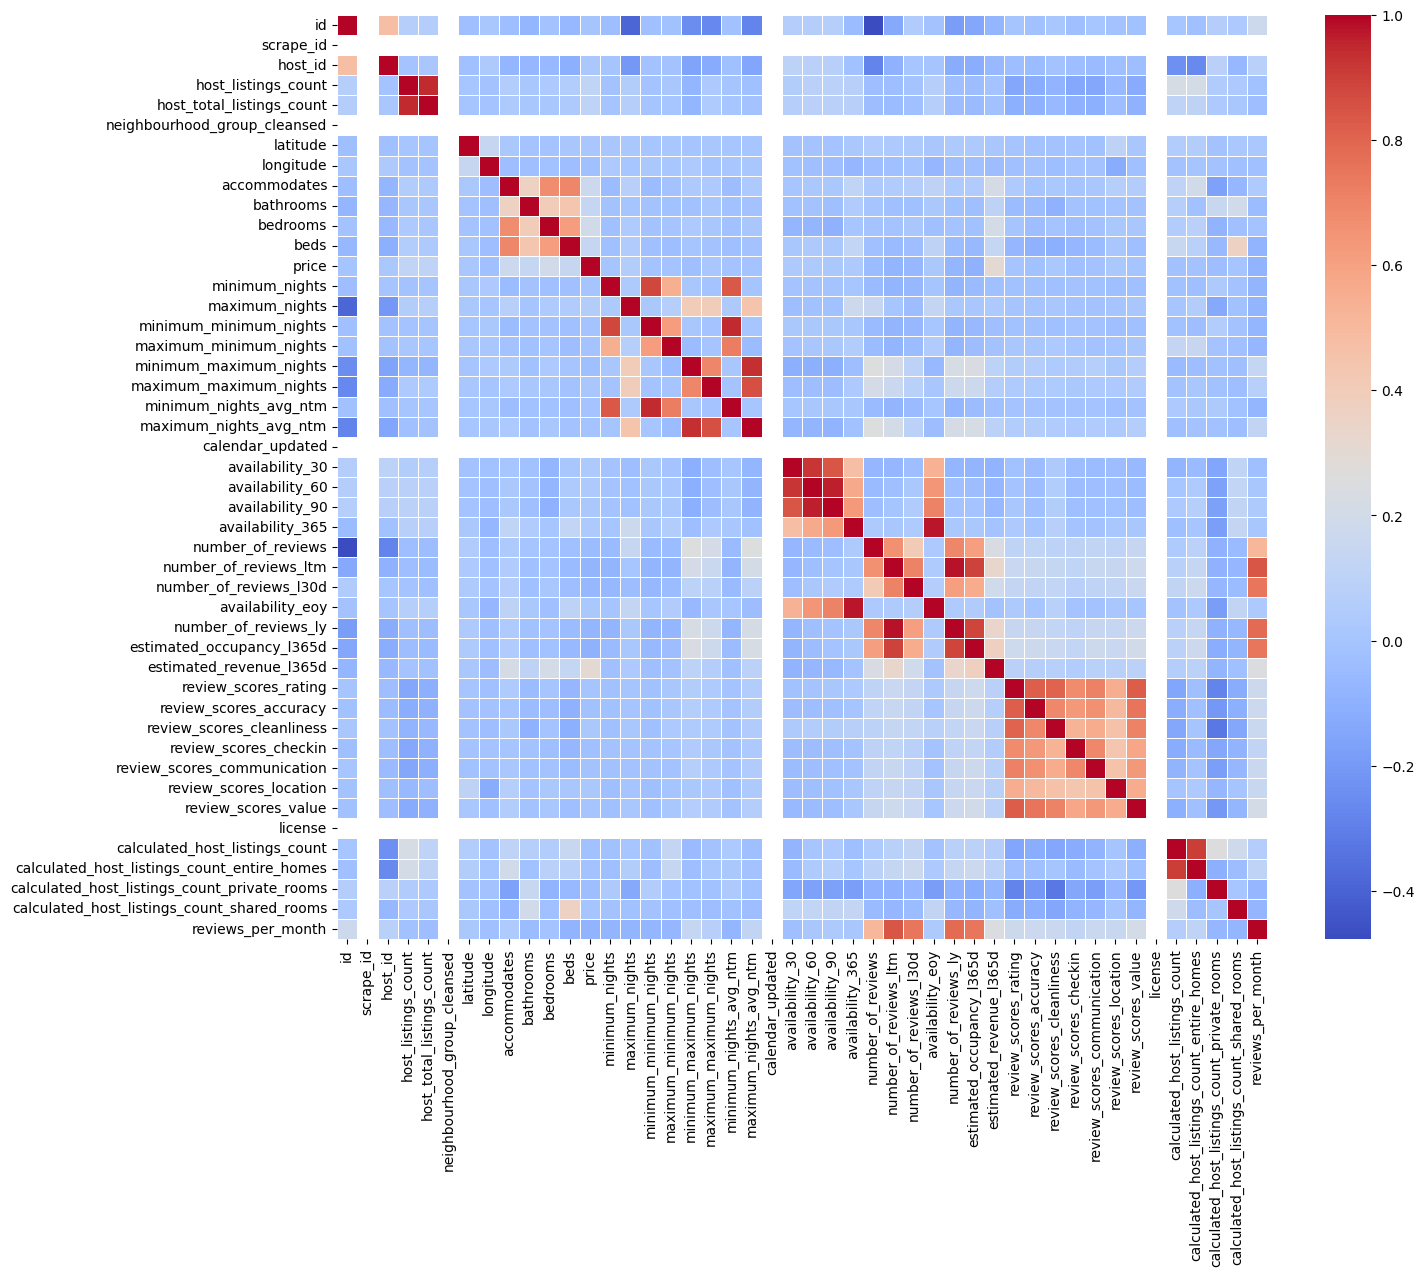

In [36]:
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.show()

In [37]:
drop_cols = [ "id", "name", "description", "license", "host_id", "host_name", "host_about", "neighborhood_overview", "neighbourhood_group_cleansed", "neighbourhood",
            "listing_url", "calendar_updated", "scrape_id", "last_scraped", "host_thumbnail_url", "listing_url", "picture_url", "host_url", "host_picture_url", "latitude","longitude", "calendar_last_scraped", "estimated_revenue_l365d", "estimated_occupancy_l365d"
    ]

In [38]:
cat_columns = [ "host_url", "host_is_superhost", "host_verifications", "host_has_profile_pic", "host_identity_verified", "neighbourhood_cleansed" " property_type", "room_type", "bathrooms_text", "has_availability", "instant_bookable", "host_verifications", "host_has_profile_pic", "host_identity_verified", "has_availability", "instant_bookable"
    ]

In [39]:
perc_col = ["host_response_rate", "host_acceptance_rate"]

In [40]:

new_columns =[
    "Coffee maker", "Bed linens", "Shampoo", "Heating", "Wifi",
    "Dishwasher", "Washer", "Wine glasses", "Pets allowed", "Patio or balcony"
]

for feature in new_columns:
    df[feature] = df['amenities'].apply(lambda x: 1 if feature in x else 0).astype("category")

df = df.drop("amenities", axis=1)
df.columns = df.columns.str.replace(" ", "")


In [41]:
df = df.drop(columns = drop_cols, axis = 1)

In [42]:
for column in perc_col:
    df = remove_percentage_and_convert_column(df, column)

In [43]:
df['host_since'] = df['host_since'].apply(extract_year)
df['host_since'] = df['host_since'].astype('float64')


df["first_review"]= df["first_review"].apply(extract_year)
df['first_review'] = df['first_review'].astype('float64')


df["last_review"]= df["last_review"].apply(extract_year)
df["last_review"] = df["last_review"].astype('float64')



In [44]:
df[["first_review", "last_review"]] = df[["first_review", "last_review"]].fillna(1900)

In [45]:
numerical_columns = df.select_dtypes(include=["number"]).columns
numerical_columns = numerical_columns.drop("price", errors="ignore")
for col in numerical_columns:

    df[col] = df[col].astype('float64')

categorical_columns = df.select_dtypes(include=["object", "category"]).columns
for col in categorical_columns:
    df[col] = df[col].astype("category")

categorical_columns

Index(['source', 'host_location', 'host_response_time', 'host_is_superhost',
       'host_neighbourhood', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'bathrooms_text', 'has_availability', 'instant_bookable',
       'Coffeemaker', 'Bedlinens', 'Shampoo', 'Heating', 'Wifi', 'Dishwasher',
       'Washer', 'Wineglasses', 'Petsallowed', 'Patioorbalcony'],
      dtype='object')

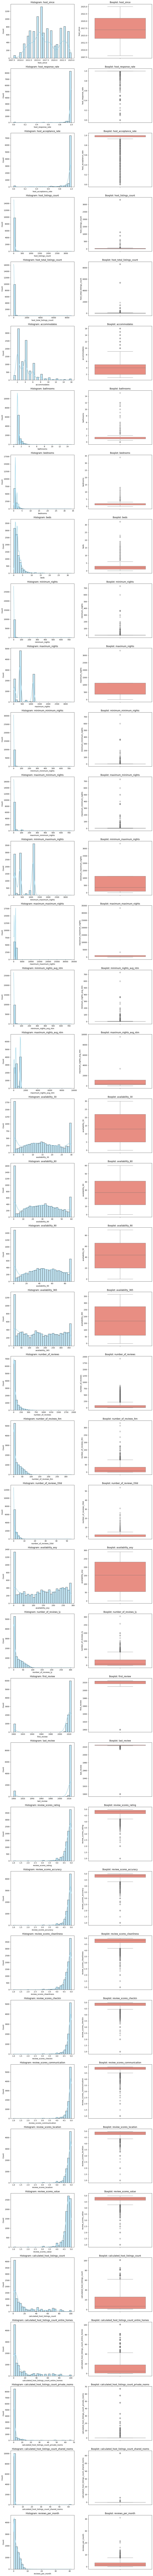

In [46]:


fig, axes = plt.subplots(len(numerical_columns), 2, figsize=(12, 5 * len(numerical_columns)))


if len(numerical_columns) == 1:
    axes = [axes]


for i, col in enumerate(numerical_columns):

    sns.histplot(df[col].dropna(), kde=True, bins=30, color="skyblue", ax=axes[i][0])
    axes[i][0].set_title(f"Histogram: {col}")


    sns.boxplot(y=df[col].dropna(), color="salmon", ax=axes[i][1])
    axes[i][1].set_title(f"Boxplot: {col}")


plt.tight_layout()
plt.show()

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


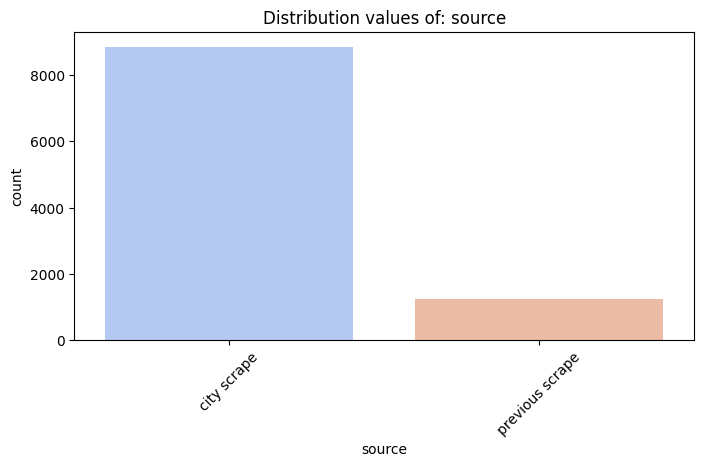

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


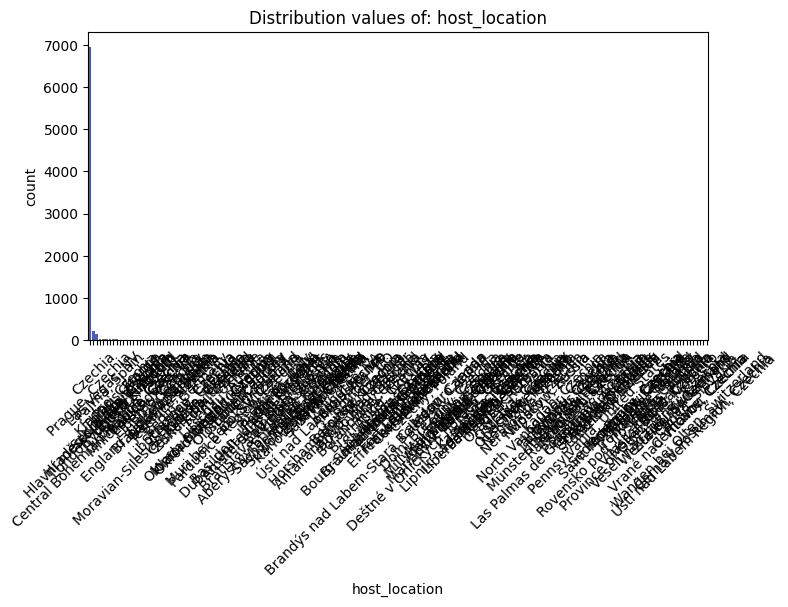

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


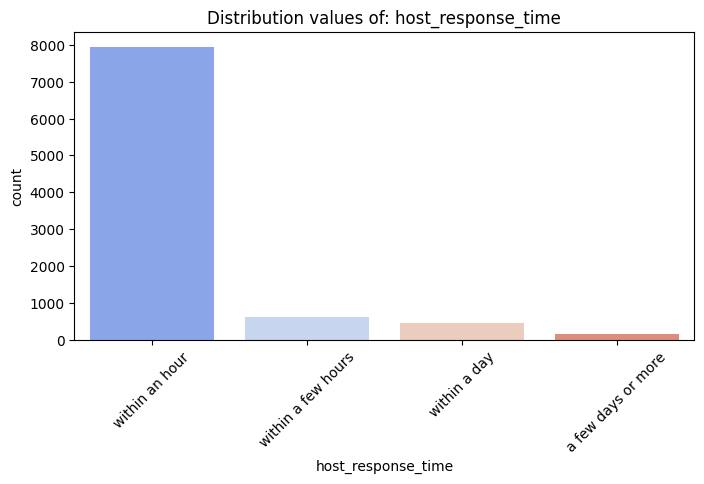

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


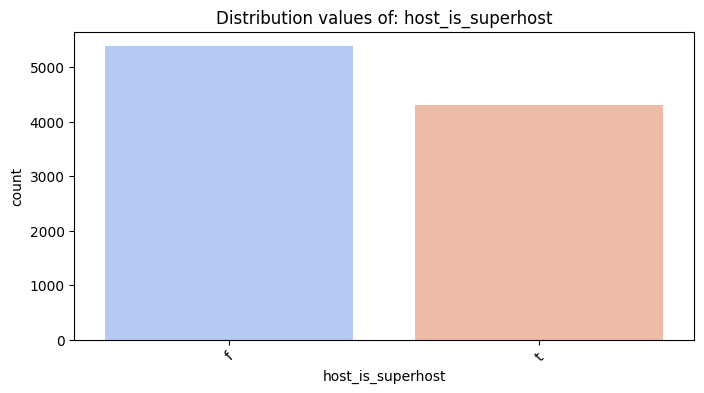

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


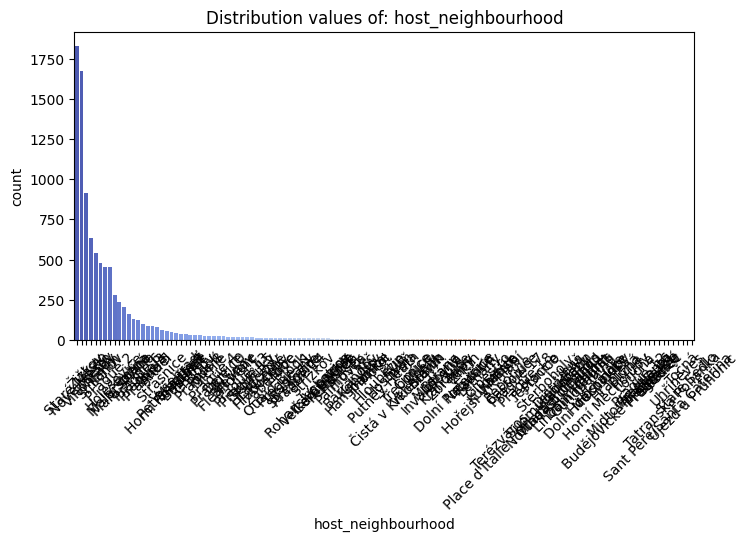

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


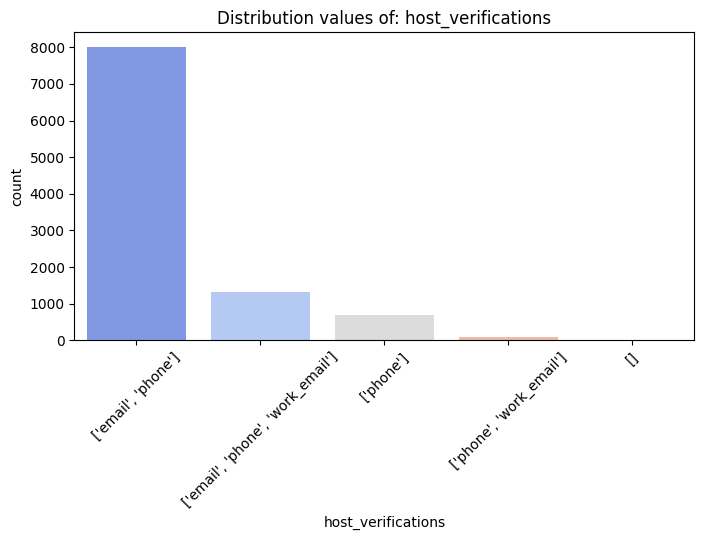

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


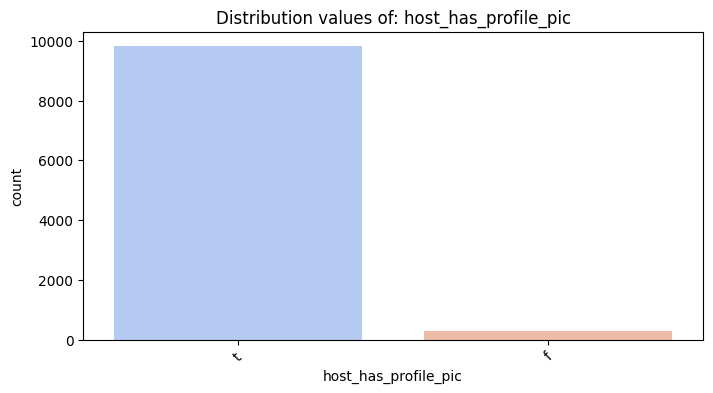

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


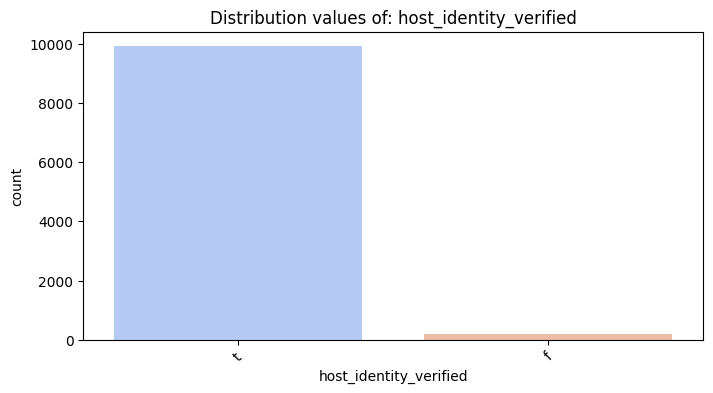

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


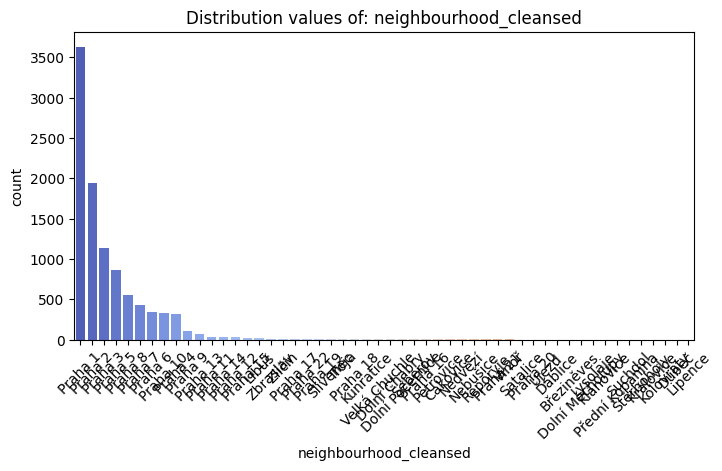

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


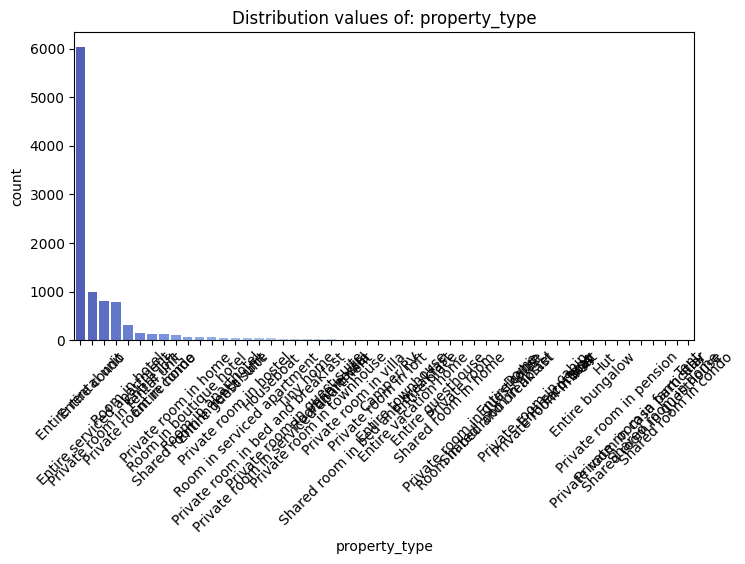

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


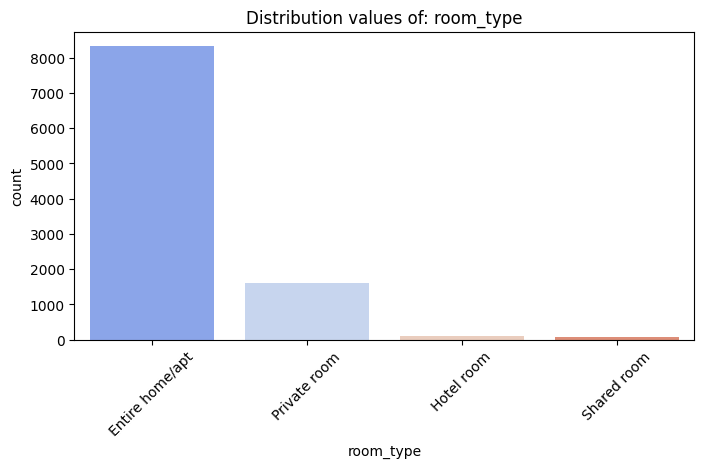

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


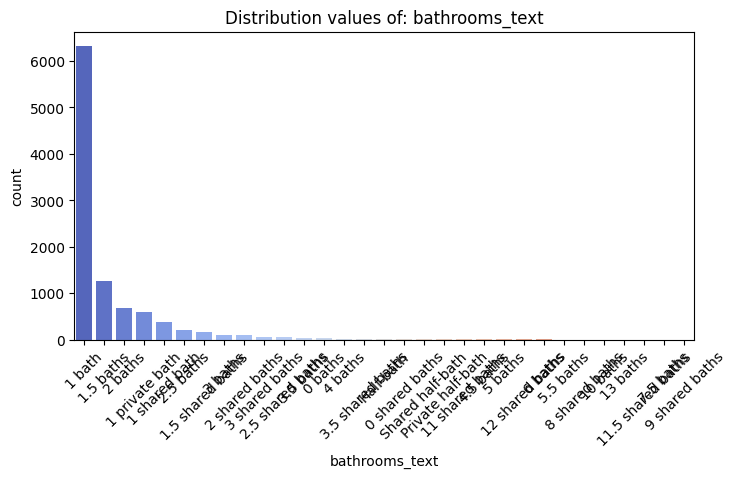

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


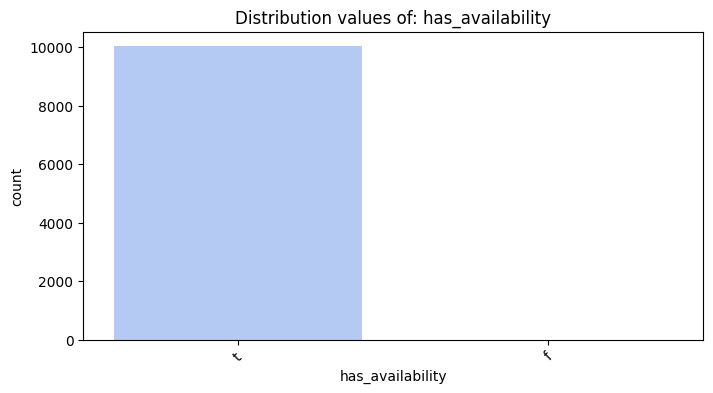

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


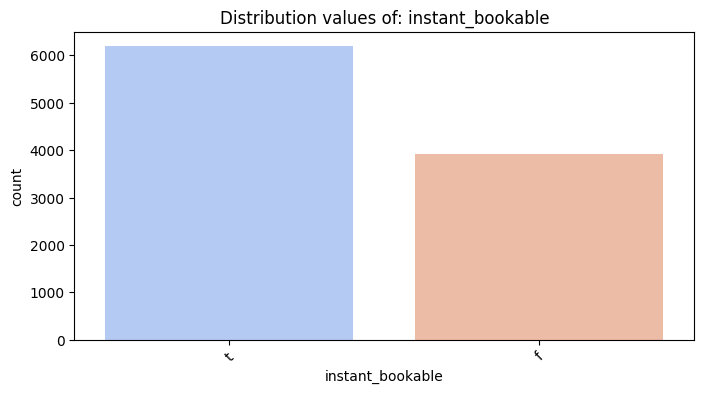

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


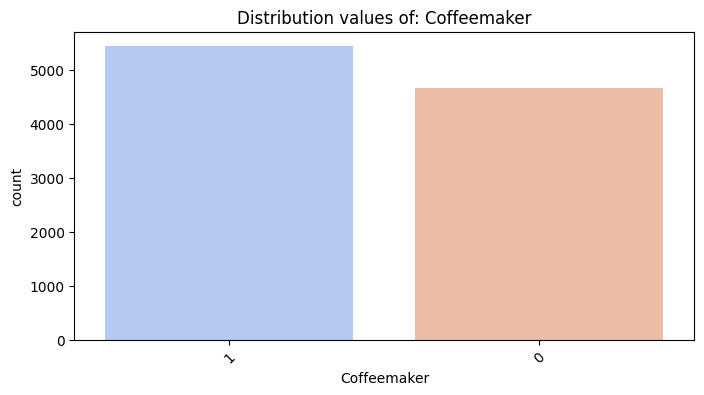

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


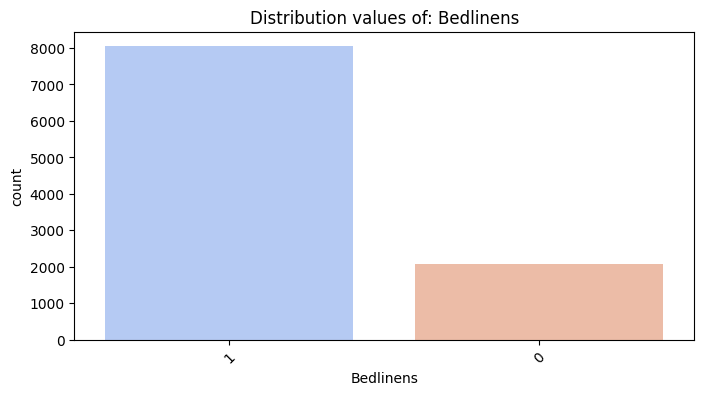

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


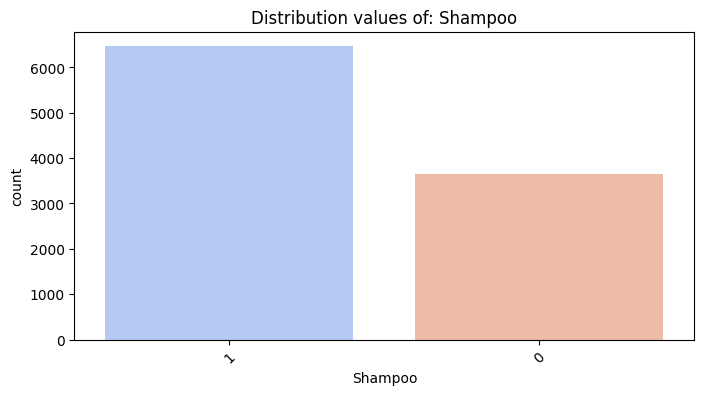

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


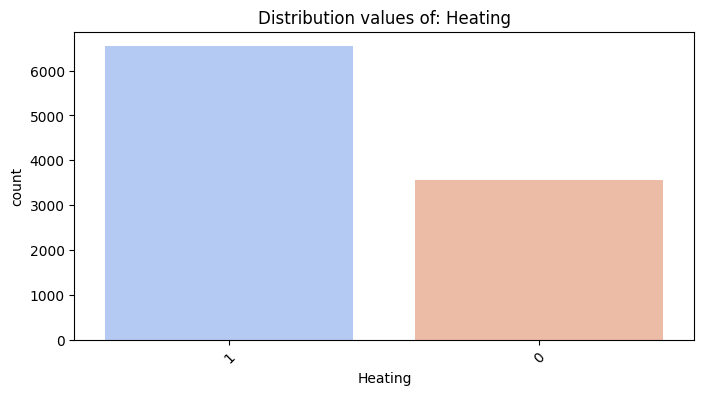

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


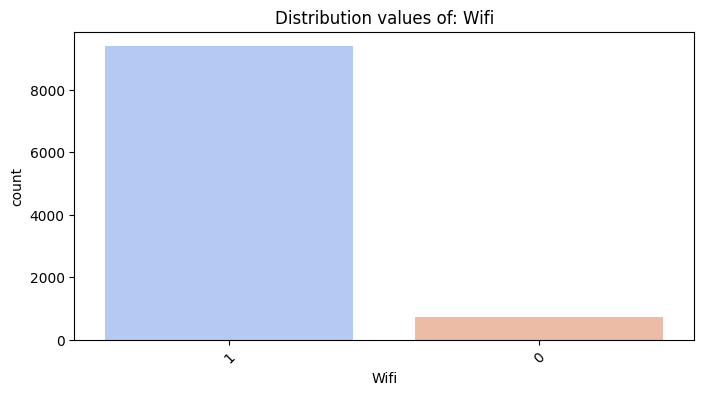

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


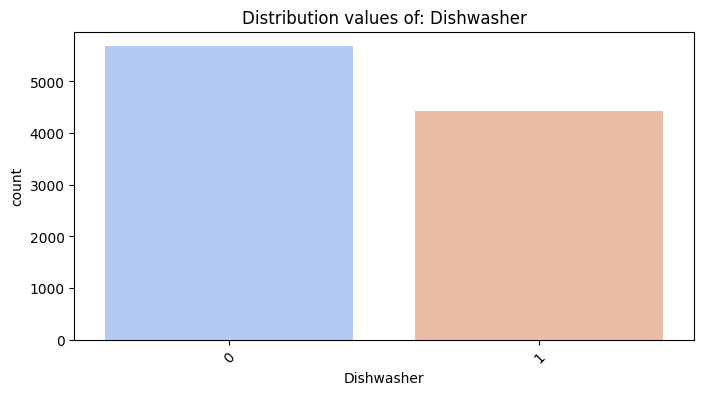

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


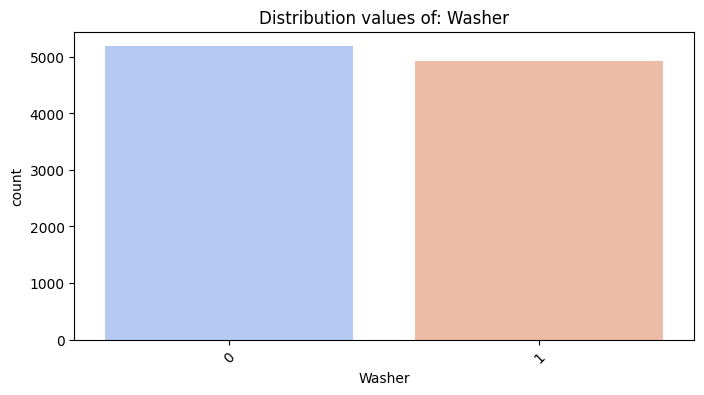

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


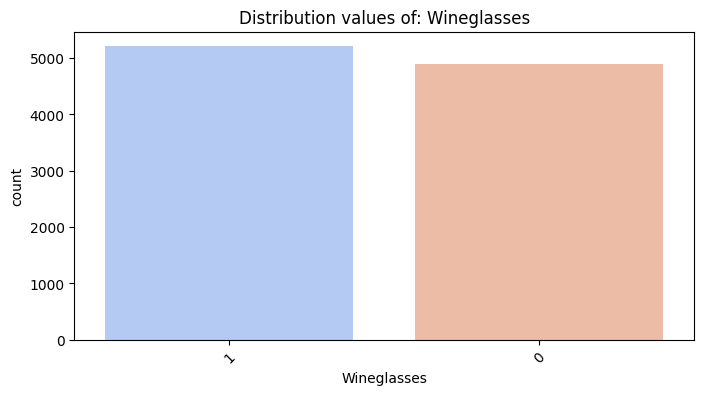

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


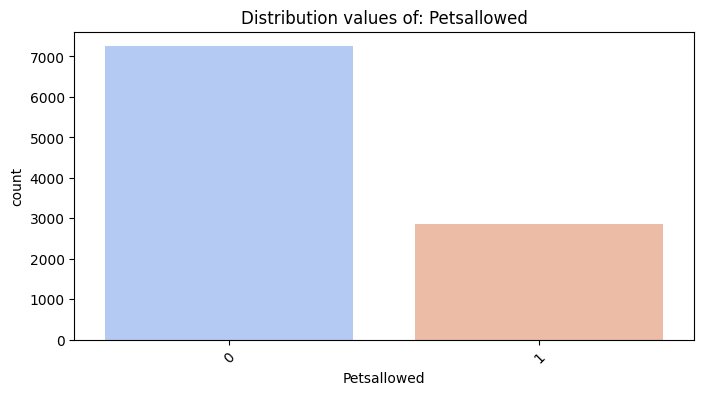

<ipython-input-47-0899bec9b67f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)


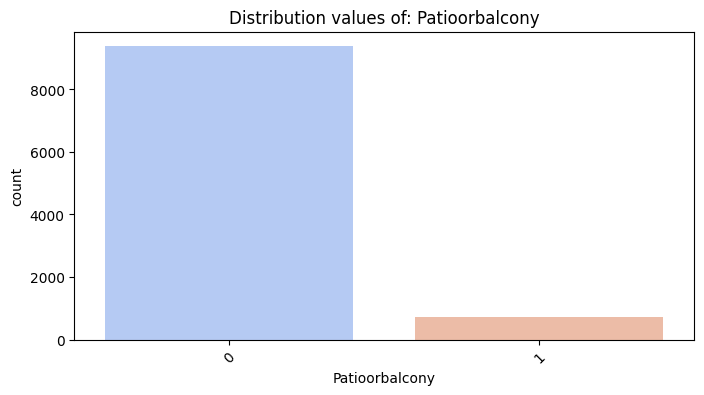

In [47]:



for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f"Distribution values of: {col}")
    plt.show()

In [48]:
df['price'] = df['price'].replace('NA', np.nan)

df = df[~df['price'].isna()]
df = df[df['price'].apply(lambda x: abs(x) >= 0.01)]

In [49]:
interim_data_path = 'data/interim/listings_interim.csv'
os.makedirs(os.path.dirname(interim_data_path), exist_ok=True)
df.to_csv(interim_data_path, index=False)

In [50]:
df['host_verifications'] = df['host_verifications'].apply(clean_verifications)


In [51]:
df.columns = df.columns.str.replace(r'[^A-Za-z0-9_]+', '', regex=True)


In [52]:
for col in numerical_columns:
    df[col] = df[col].replace('NA', np.nan)


In [53]:
X = df.drop("price",axis=1)
y = df["price"]

In [54]:
X.head()


source  host_since    host_location host_response_time  \
0  city scrape      2008.0  Prague, Czechia     within an hour   
2  city scrape      2010.0  Prague, Czechia     within an hour   
3  city scrape      2012.0  Prague, Czechia     within an hour   
4  city scrape      2012.0  Prague, Czechia     within an hour   
5  city scrape      2012.0  Prague, Czechia     within an hour   

   host_response_rate  host_acceptance_rate host_is_superhost  \
0                 1.0                  1.00                 t   
2                 1.0                  0.98                 t   
3                 1.0                  0.80                 t   
4                 1.0                  0.80                 t   
5                 1.0                  0.80                 t   

  host_neighbourhood  host_listings_count  host_total_listings_count  \
0            Josefov                 72.0                       82.0   
2        Staré Město                  4.0                        4.0   
3             Žižkov                  6.0                        6.0   
4             Žižkov                  6.0                        6.0   
5             Žižkov                  6.0                        6.0   

  host_verifications host_has_profile_pic host_identity_verified  \
0        email_phone                    t                      t   
2        email_phone                    t                      t   
3        email_phone                    t                      t   
4        email_phone                    t                      t   
5        email_phone                    t                      t   

  neighbourhood_cleansed                property_type        room_type  \
0                Praha 1           Entire rental unit  Entire home/apt   
2                Praha 1           Entire rental unit  Entire home/apt   
3                Praha 3  Private room in rental unit     Private room   
4                Praha 3  Private room in rental unit     Private room   
5                Praha 3  Private room in rental unit     Private room   

   accommodates  bathrooms  bathrooms_text  bedrooms  beds  minimum_nights  \
0           4.0        1.0          1 bath       1.0   2.0             1.0   
2           4.0        1.5       1.5 baths       1.0   2.0             3.0   
3           2.0        1.0  1 private bath       1.0   2.0             3.0   
4           2.0        1.0  1 private bath       1.0   3.0             3.0   
5           2.0        1.0  1 private bath       1.0   1.0             3.0   

   maximum_nights  minimum_minimum_nights  maximum_minimum_nights  \
0           365.0                     1.0                     7.0   
2           700.0                     3.0                     4.0   
3            60.0                     1.0                     3.0   
4            60.0                     3.0                     3.0   
5            60.0                     3.0                     3.0   

   minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  \
0                    60.0                   731.0                     1.4   
2                  1125.0                  1125.0                     3.1   
3                    60.0                    60.0                     3.0   
4                    60.0                    60.0                     3.0   
5                    60.0                    60.0                     3.0   

   maximum_nights_avg_ntm has_availability  availability_30  availability_60  \
0                   663.6                t              0.0              0.0   
2                  1125.0                t              3.0              7.0   
3                    60.0                t              5.0              5.0   
4                    60.0                t              3.0              3.0   
5                    60.0                t              6.0              6.0   

   availability_90  availability_365  number_of_reviews  \
0              0.0               0.0          

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle = True)

In [56]:
from functools import partial


optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
optuna_objective = partial(objective, X_train=X_train, y_train=y_train)
# n_trials intially set to higher values
study.optimize(optuna_objective, n_trials=1, show_progress_bar=True)


best_trial = study.best_trial
best_model = best_trial.user_attrs["model"]
num_imputer = best_trial.user_attrs["imputers"][0]
cat_imputer = best_trial.user_attrs["imputers"][1]
encoder = best_trial.user_attrs.get("encoder")
scaler = best_trial.user_attrs.get("scaler")
x_tr = best_trial.user_attrs.get("x_tr")
y_tr = best_trial.user_attrs.get("y_tr")
x_val = best_trial.user_attrs.get("x_val")
y_val = best_trial.user_attrs.get("y_val")


[I 2025-04-22 20:21:34,928] A new study created in memory with name: no-name-6110c138-c419-4554-ad45-fc451156bd78


  0%|          | 0/1 [00:00<?, ?it/s]

Testing trial with params: {'n_estimators': 87, 'booster': 'gbtree', 'learning_rate': 0.046187109390049115, 'max_depth': 4, 'min_child_weight': 16, 'subsample': 0.44680559213273097, 'colsample_bytree': 0.4467983561008608, 'reg_lambda': 10.580836121681994, 'gamma': 8.92940916619948, 'reg_alpha': 2.2022300234864174, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}
Kategorie: ['source', 'host_location', 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'has_availability', 'instant_bookable', 'Coffeemaker', 'Bedlinens', 'Shampoo', 'Heating', 'Wifi', 'Dishwasher', 'Washer', 'Wineglasses', 'Petsallowed', 'Patioorbalcony']
[YOutlierRemover] Previous number of rows: 4697
[YOutlierRemover] Removed 100 rows with outliers in y.
[YOutlierRemover] After removing left: 4597
[YOutlierRemover] Previous number of rows: 2349
[YOutlierRem

<ipython-input-18-0e2ded4ef36e>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(most_frequent, inplace=True)
<ipython-input-18-0e2ded4ef36e>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

Po OneHotEncode:
Score: -509.8300282808495
Prediction: [1743.4537  2908.175   1019.44696 2322.8965  3331.2642 ]...
Kategorie: ['source', 'host_location', 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'has_availability', 'instant_bookable', 'Coffeemaker', 'Bedlinens', 'Shampoo', 'Heating', 'Wifi', 'Dishwasher', 'Washer', 'Wineglasses', 'Petsallowed', 'Patioorbalcony']
[YOutlierRemover] Previous number of rows: 4697
[YOutlierRemover] Removed 117 rows with outliers in y.
[YOutlierRemover] After removing left: 4580
[YOutlierRemover] Previous number of rows: 2349
[YOutlierRemover] Removed 47 rows with outliers in y.
[YOutlierRemover] After removing left: 2302
[XOutlierRemover] Previous number of rows: 4580
[XOutlierRemover] Removed 1265 rows with outliers in X.
[XOutlierRemover] After removing left: 3315
[XOutlierRemover] Previo

<ipython-input-18-0e2ded4ef36e>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(most_frequent, inplace=True)
<ipython-input-18-0e2ded4ef36e>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

Score: -517.5720708046006
Prediction: [1680.1421 1662.4601 1468.3853 1197.2612  898.3722]...
Kategorie: ['source', 'host_location', 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'has_availability', 'instant_bookable', 'Coffeemaker', 'Bedlinens', 'Shampoo', 'Heating', 'Wifi', 'Dishwasher', 'Washer', 'Wineglasses', 'Petsallowed', 'Patioorbalcony']
[YOutlierRemover] Previous number of rows: 4698
[YOutlierRemover] Removed 102 rows with outliers in y.
[YOutlierRemover] After removing left: 4596
[YOutlierRemover] Previous number of rows: 2348
[YOutlierRemover] Removed 55 rows with outliers in y.
[YOutlierRemover] After removing left: 2293
[XOutlierRemover] Previous number of rows: 4596
[XOutlierRemover] Removed 1248 rows with outliers in X.
[XOutlierRemover] After removing left: 3348
[XOutlierRemover] Previous number of rows: 229

<ipython-input-18-0e2ded4ef36e>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(most_frequent, inplace=True)
<ipython-input-18-0e2ded4ef36e>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

Score: -527.8680253396105
Prediction: [1876.2917 3367.818  4455.7827 1277.6301 1752.8109]...
Score: -518.4233748083535, type: <class 'numpy.float64'>
[Trial 0] Done with score: -518.4233748083535
[I 2025-04-22 20:22:52,727] Trial 0 finished with value: -518.4233748083535 and parameters: {'n_estimators': 87, 'learning_rate': 0.046187109390049115, 'max_depth': 4, 'min_child_weight': 16, 'subsample': 0.44680559213273097, 'colsample_bytree': 0.4467983561008608, 'reg_lambda': 10.580836121681994, 'gamma': 8.92940916619948, 'reg_alpha': 2.2022300234864174}. Best is trial 0 with value: -518.4233748083535.


In [57]:
if not hasattr(num_imputer, 'transform') or not hasattr(cat_imputer, 'transform'):
    raise ValueError("Provided imputers are not valid transformers")


In [58]:
pipeline = {
    "model": best_model,
    "numerical_imputer": num_imputer,
    "categorical_imputer": cat_imputer,
    "encoder": encoder,
    "scaler": scaler
}

In [59]:
with open("best_model_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

In [60]:
with open("best_model_pipeline.pkl", "rb") as f:
    loaded_pipeline = pickle.load(f)

model = loaded_pipeline["model"]
num_imputer = loaded_pipeline["numerical_imputer"]
cat_imputer = loaded_pipeline["categorical_imputer"]
encoder = loaded_pipeline["encoder"]

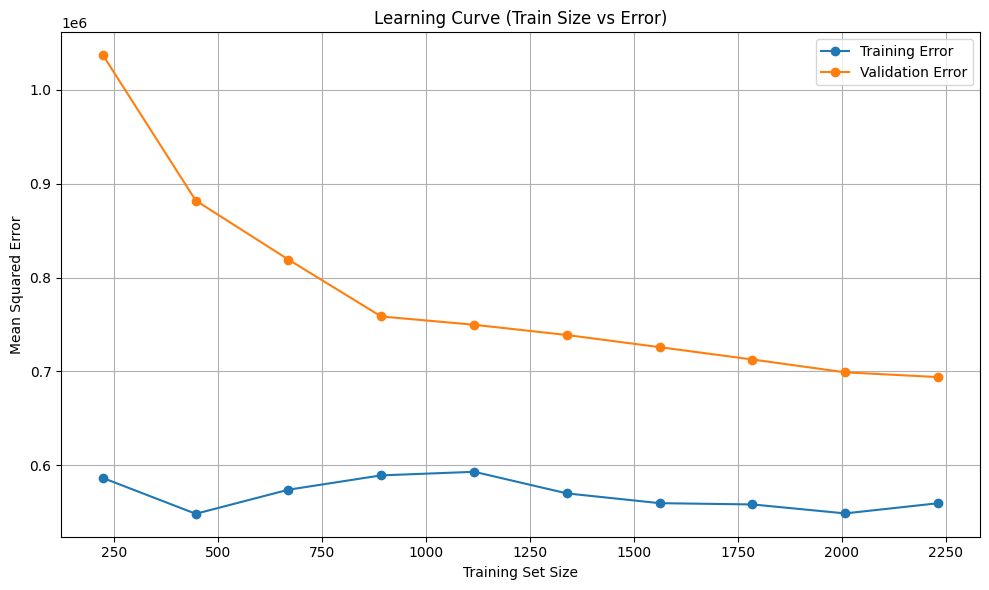

In [61]:
X_tr = best_trial.user_attrs.get("x_tr")
y_tr = best_trial.user_attrs.get("y_tr")

plot_learning_curve_vs_data_size(best_model, x_tr, y_tr)

In [62]:
X_test_transformed = transform_with_best_pipeline(X_test, num_imputer, cat_imputer, encoder, scaler, X_train.columns)
y_pred = model.predict(X_test_transformed)
y_pred = np.clip(y_pred, a_min=0, a_max=None)


<ipython-input-18-0e2ded4ef36e>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_copy[col].fillna(most_frequent, inplace=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 8, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Evaluace

In [63]:
# last fold from cross-val, no fixed val set
y_val_pred =  model.predict(x_val)
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
r2 = r2_score(y_val, y_val_pred)

print(f"Mean Absolute Error (MAE):            {mae:,.2f}")
print(f"Mean Squared Error (MSE):             {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE):       {rmse:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² (coefficient of determination):     {r2:.4f}")

Mean Absolute Error (MAE):            527.87
Mean Squared Error (MSE):             688,361.44
Root Mean Squared Error (RMSE):       829.68
Mean Absolute Percentage Error (MAPE): 29.24%
R² (coefficient of determination):     0.5534


In [64]:
# last folds from cross-val, no fixed train set
y_tr_pred =  model.predict(X_tr)
mae = mean_absolute_error(y_tr, y_tr_pred)
mse = mean_squared_error(y_tr, y_tr_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_tr - y_tr_pred) / y_tr)) * 100
r2 = r2_score(y_tr, y_tr_pred)

print(f"Mean Absolute Error (MAE):            {mae:,.2f}")
print(f"Mean Squared Error (MSE):             {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE):       {rmse:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² (coefficient of determination):     {r2:.4f}")

Mean Absolute Error (MAE):            481.35
Mean Squared Error (MSE):             572,483.62
Root Mean Squared Error (RMSE):       756.63
Mean Absolute Percentage Error (MAPE): 26.39%
R² (coefficient of determination):     0.6421


In [65]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE):            {mae:,.2f}")
print(f"Mean Squared Error (MSE):             {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE):       {rmse:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² (coefficient of determination):     {r2:.4f}")

Mean Absolute Error (MAE):            1,374.31
Mean Squared Error (MSE):             102,886,029.62
Root Mean Squared Error (RMSE):       10,143.28
Mean Absolute Percentage Error (MAPE): 35.81%
R² (coefficient of determination):     0.0237


Actual vs Predicted

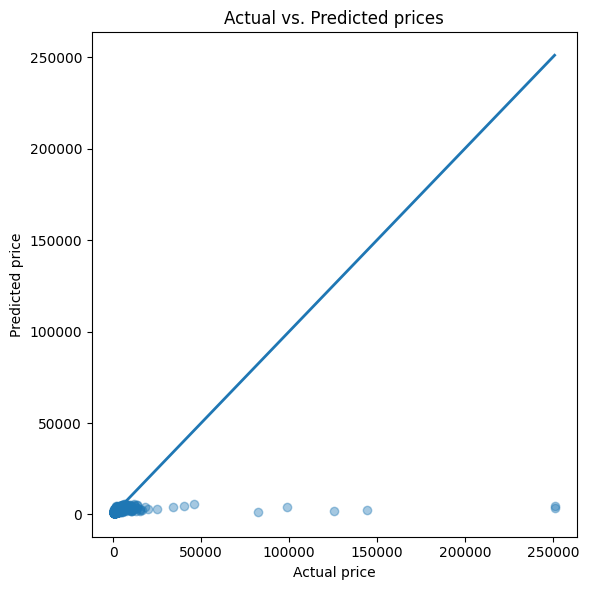

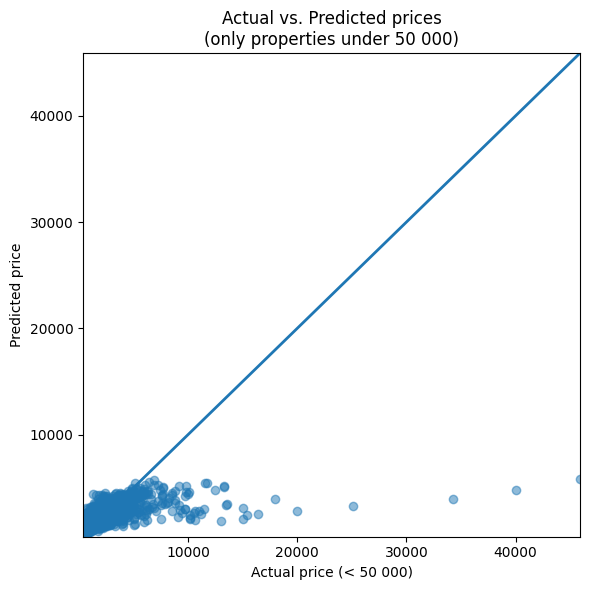

In [66]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
lim = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lim, lim, lw=2)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Actual vs. Predicted prices")
plt.tight_layout()
plt.show()


mask = y_test < 50_000
y_test_low  = y_test[mask]
y_pred_low  = y_pred[mask]
plt.figure(figsize=(6, 6))
plt.scatter(y_test_low, y_pred_low, alpha=0.5)
lim = [
    min(y_test_low.min(),  y_pred_low.min()),
    max(y_test_low.max(),  y_pred_low.max())]
plt.plot(lim, lim, lw=2)
plt.xlim(lim);  plt.ylim(lim)
plt.xlabel("Actual price (< 50 000)")
plt.ylabel("Predicted price")
plt.title("Actual vs. Predicted prices\n(only properties under 50 000)")
plt.tight_layout()
plt.show()

Residuals

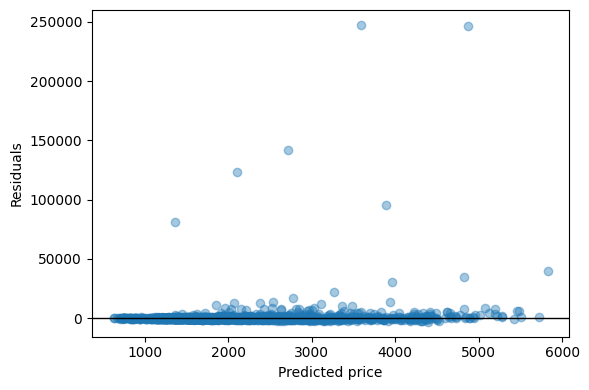

In [67]:
residuals = y_test - y_pred

fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(y_pred, residuals, alpha=0.4)
ax.axhline(0, c="k", lw=1)
ax.set_xlabel("Predicted price")
ax.set_ylabel("Residuals")
plt.tight_layout()
plt.show()

Feature Importances

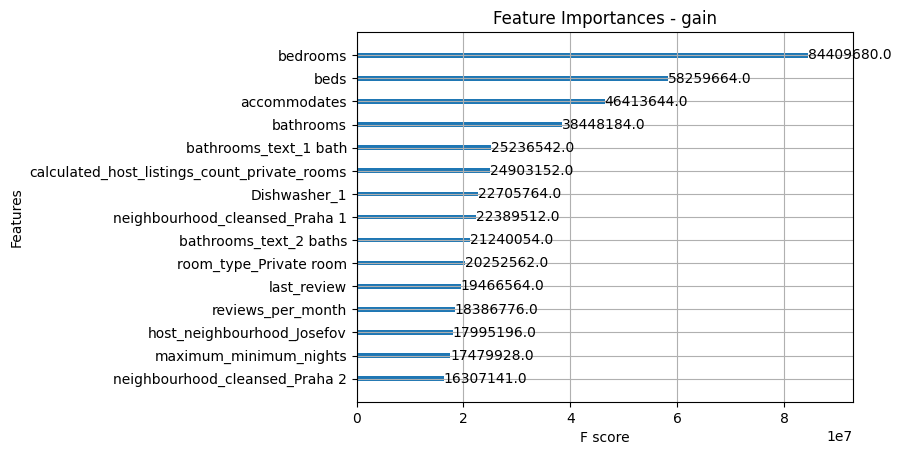

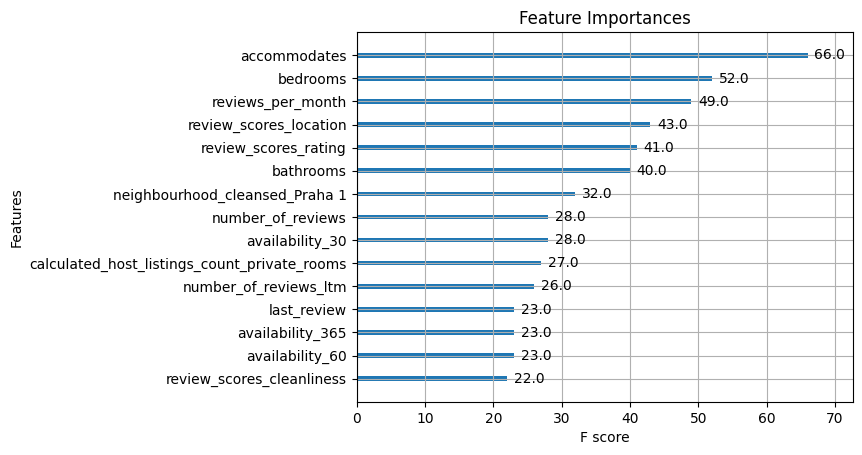

In [68]:
xgb.plot_importance(best_model, max_num_features=15, importance_type="gain")
plt.title("Feature Importances - gain")
plt.show()

xgb.plot_importance(best_model, max_num_features=15)
plt.title("Feature Importances")
plt.show()

Permutation Importance

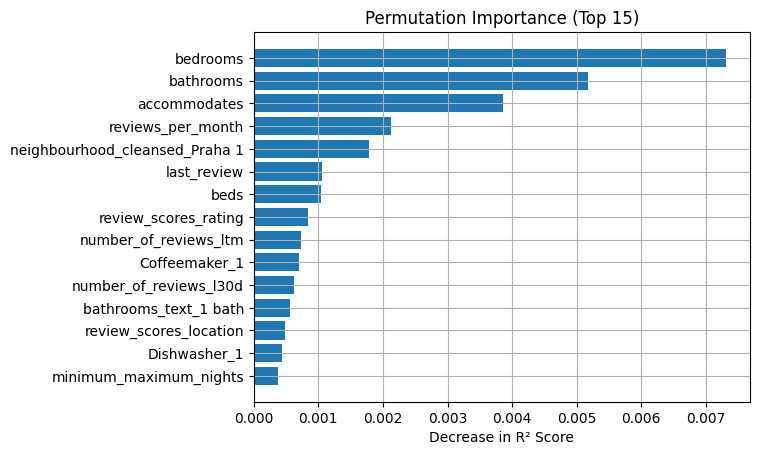

In [69]:
result = permutation_importance(best_model, X_test_transformed, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]

plt.barh(np.array(X_test_transformed.columns)[sorted_idx][:15][::-1],
         result.importances_mean[sorted_idx][:15][::-1])
plt.title("Permutation Importance (Top 15)")
plt.xlabel("Decrease in R² Score")
plt.grid(True)
plt.show()